# Modelo 3 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("reservaciones_clean.csv")
df.drop(columns="Cliente_Disp",inplace=True)
df.head()

,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,ID_Paquete,ID_Segmento_Comp,ID_Agencia,ID_empresa,ID_Tipo_Habitacion,ID_canal,h_fec_lld_ok,h_fec_sda_ok,Reservacion,ID_estatus_reservaciones,h_can_res,h_cod_reserva,h_edo,h_codigop,h_tfa_total
0,2,2,0,3,1,1,14,112,1,25,10,2019-11-07,2019-11-10,1,9,9,31047,85,333,2659.98
1,4,4,0,4,1,2,14,112,1,25,10,2019-12-01,2019-12-05,1,9,9,31047,54,398,1764.00
2,2,2,0,4,1,1,14,112,1,23,10,2019-12-01,2019-12-05,1,9,9,31047,75,6566,2660.04
3,4,3,0,3,1,2,14,112,1,24,10,2019-12-08,2019-12-11,1,9,9,31047,54,2961,1995.03
4,2,2,0,4,1,1,5,14,1,4,13,2019-12-08,2019-12-12,1,9,12,23266,85,1224,13369.92


In [3]:
df['h_fec_lld_ok']=pd.to_datetime(df['h_fec_lld_ok'])
df['h_fec_sda_ok']=pd.to_datetime(df['h_fec_sda_ok'])
df['h_fec_sda_ok']=df['h_fec_sda_ok'].astype('int64')/1e9
df=df.sort_values('h_fec_lld_ok')

In [4]:
df2=df.copy()
df2=df2[['h_fec_lld_ok','h_tfa_total']]
df2=df2.groupby('h_fec_lld_ok').sum().reset_index()

Text(0.5, 0, 'h_fec_lld_ok')

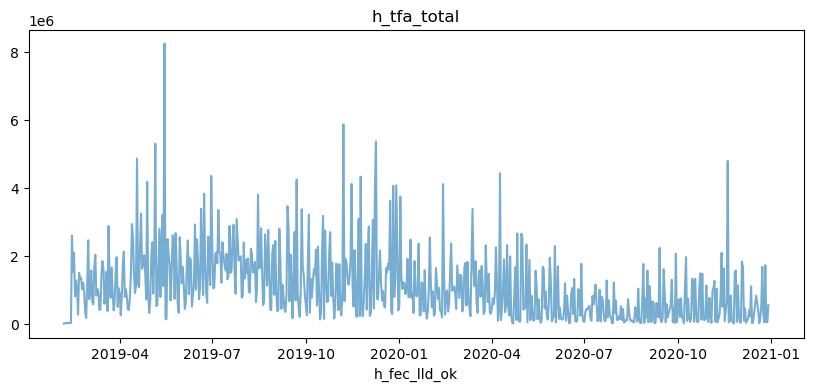

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['h_tfa_total'], linestyle='-', alpha=0.6)
plt.title('h_tfa_total')
plt.xlabel('h_fec_lld_ok')

## Suavizado

In [6]:
from scipy.signal import savgol_filter
df2['smoothed'] = df2['h_tfa_total'].rolling(window=7).mean() #media movil simple
df2['smoothed2'] = df2['h_tfa_total'].ewm(span=7, adjust=False).mean() # Suavizado exponencial
df2['smoothed3'] = savgol_filter(df2['h_tfa_total'], window_length=15, polyorder=2)

Text(0.5, 0, 'Fecha')

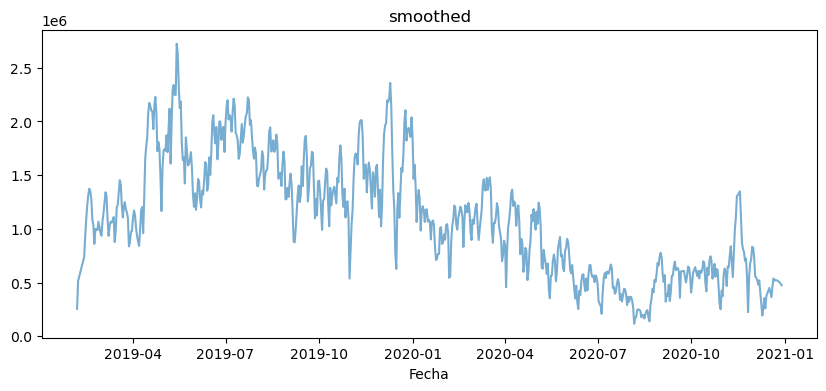

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['smoothed3'], linestyle='-', alpha=0.6)
plt.title('smoothed')
plt.xlabel('Fecha')

In [8]:
df2

,h_fec_lld_ok,h_tfa_total,smoothed,smoothed2,smoothed3
0,2019-02-05,6.728000e+02,NaN,672.800000,2.556075e+05
1,2019-02-06,1.105200e+04,NaN,3267.600000,5.139218e+05
2,2019-02-12,1.899920e+04,NaN,7200.500000,7.393984e+05
3,2019-02-13,2.593320e+06,NaN,653730.373708,9.320373e+05
4,2019-02-14,1.519103e+06,NaN,870073.407775,1.091839e+06
...,...,...,...,...,...
676,2020-12-25,3.877740e+04,438878.822258,443346.818266,5.172565e+05
677,2020-12-26,1.718680e+06,627977.595115,762180.033699,5.107749e+05
678,2020-12-27,4.606200e+04,632748.309401,583150.525274,5.014832e+05
679,2020-12-28,4.478400e+04,619656.023686,448558.893956,4.893817e+05


In [9]:
df2['h_fec_lld_ok']


0     2019-02-05
1     2019-02-06
2     2019-02-12
3     2019-02-13
4     2019-02-14
         ...    
676   2020-12-25
677   2020-12-26
678   2020-12-27
679   2020-12-28
680   2020-12-29
Name: h_fec_lld_ok, Length: 681, dtype: datetime64[ns]

## Prophet

In [10]:
import itertools
import holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

In [11]:
df_prophet=df2[["h_fec_lld_ok","smoothed2"]]
df_prophet

,h_fec_lld_ok,smoothed2
0,2019-02-05,672.800000
1,2019-02-06,3267.600000
2,2019-02-12,7200.500000
3,2019-02-13,653730.373708
4,2019-02-14,870073.407775
...,...,...
676,2020-12-25,443346.818266
677,2020-12-26,762180.033699
678,2020-12-27,583150.525274
679,2020-12-28,448558.893956


In [ ]:
#Camibiar el nombre de la variable de tiempo y la que se quiere predecir, para que el modelo prophet pueda reconocerlas
df_prophet= df_prophet[['h_fec_lld_ok', 'smoothed2']].rename(columns={'h_fec_lld_ok': 'ds','smoothed2': 'y'})

In [13]:
df_prophet

,ds,y
0,2019-02-05,672.800000
1,2019-02-06,3267.600000
2,2019-02-12,7200.500000
3,2019-02-13,653730.373708
4,2019-02-14,870073.407775
...,...,...
676,2020-12-25,443346.818266
677,2020-12-26,762180.033699
678,2020-12-27,583150.525274
679,2020-12-28,448558.893956


In [14]:
from plotly.express import line

line(data_frame=df_prophet, x='ds',y='y')

### Train-test split and future

In [15]:
# train_df=df_prophet[df_prophet['ds']<='2020-08-02'] #80% de los datos
# test_df=df_prophet[df_prophet['ds']>='2020-08-02'] #20% de los datos

futuro = pd.DataFrame({
    'ds': pd.date_range(start='2020-12-30', periods=15, freq='D'), # Dataset de futuro
    'y': np.nan
})


### Modelo prophet básico

In [16]:

# instanciamos modelo
m = Prophet()

# fiteamos el modelo en TRAIN
#m.fit(train_df)
m.fit(df_prophet)

# para graficar, hacemos predict tambien en train
forecast = m.predict(df_prophet)

17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing


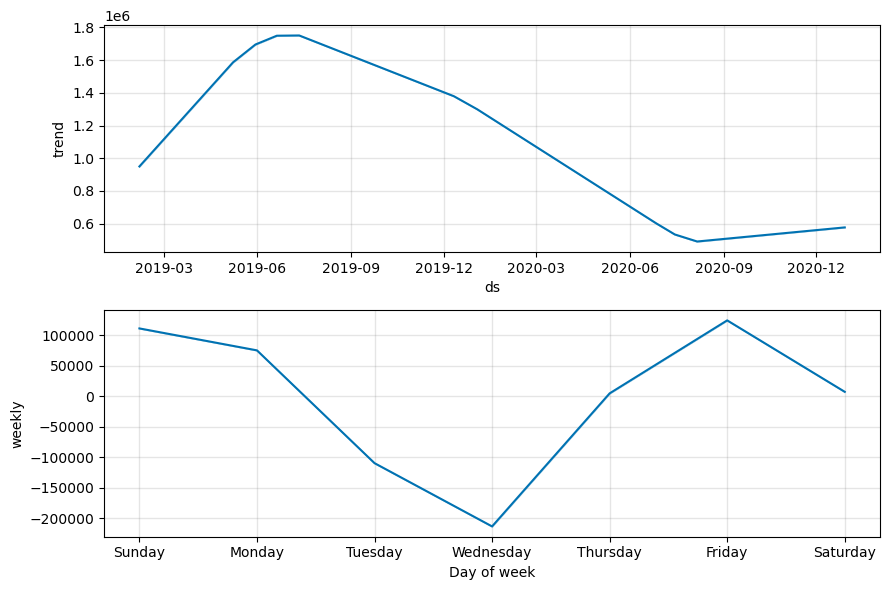

In [17]:
# #plot componentes del forecast
m.plot_components(forecast);

In [18]:
## Predecimos con el test
forecast = m.predict(futuro)

In [19]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-30,577734.978743,-9734.450479,7.410451e+05,577734.978743,577734.978743,-213658.186026,-213658.186026,-213658.186026,-213658.186026,-213658.186026,-213658.186026,0.0,0.0,0.0,364076.792717
1,2020-12-31,578329.237865,225533.442660,9.572956e+05,578329.237865,578329.237865,4767.423323,4767.423323,4767.423323,4767.423323,4767.423323,4767.423323,0.0,0.0,0.0,583096.661188
2,2021-01-01,578923.496987,336315.868360,1.041278e+06,578923.496987,578923.496987,124589.384357,124589.384357,124589.384357,124589.384357,124589.384357,124589.384357,0.0,0.0,0.0,703512.881344
3,2021-01-02,579517.756109,199287.255905,9.535129e+05,579517.756109,579517.756109,7337.267463,7337.267463,7337.267463,7337.267463,7337.267463,7337.267463,0.0,0.0,0.0,586855.023572
4,2021-01-03,580112.015231,325959.945125,1.051147e+06,580112.015231,580112.015231,111385.005723,111385.005723,111385.005723,111385.005723,111385.005723,111385.005723,0.0,0.0,0.0,691497.020955
5,2021-01-04,580706.274353,287524.908611,1.024103e+06,580704.912596,580706.274353,75359.883997,75359.883997,75359.883997,75359.883997,75359.883997,75359.883997,0.0,0.0,0.0,656066.158351
6,2021-01-05,581300.533475,101151.996861,7.850819e+05,581116.481180,581359.061078,-109780.778837,-109780.778837,-109780.778837,-109780.778837,-109780.778837,-109780.778837,0.0,0.0,0.0,471519.754638
7,2021-01-06,581894.792597,20574.156997,7.190170e+05,581510.856793,582108.038131,-213658.186026,-213658.186026,-213658.186026,-213658.186026,-213658.186026,-213658.186026,0.0,0.0,0.0,368236.606571
8,2021-01-07,582489.051719,236664.416234,9.570491e+05,581687.272737,582894.014053,4767.423323,4767.423323,4767.423323,4767.423323,4767.423323,4767.423323,0.0,0.0,0.0,587256.475042
9,2021-01-08,583083.310842,359997.060721,1.059835e+06,581864.571314,583764.187604,124589.384357,124589.384357,124589.384357,124589.384357,124589.384357,124589.384357,0.0,0.0,0.0,707672.695198


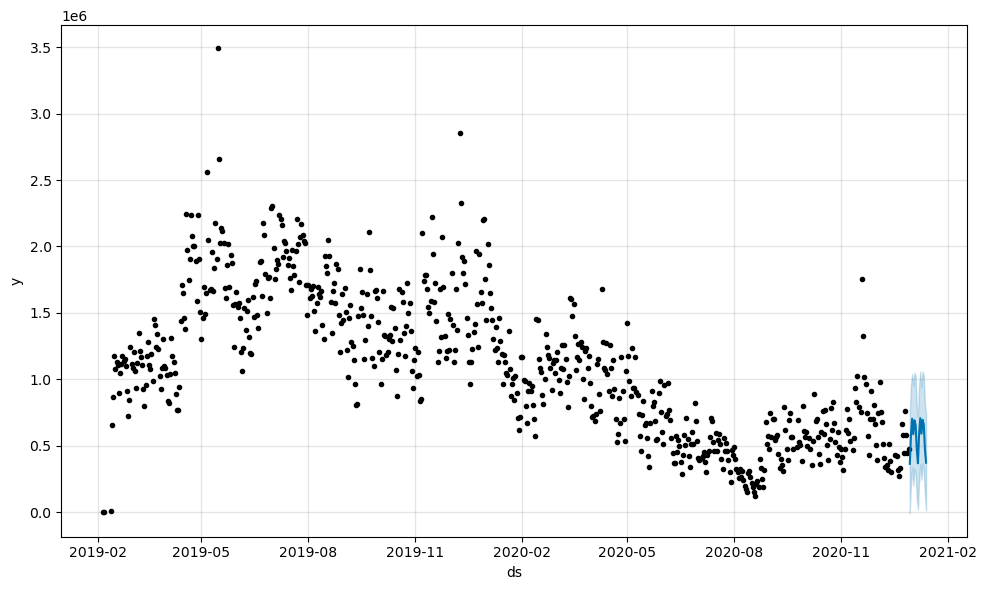

In [20]:
m.plot(forecast);

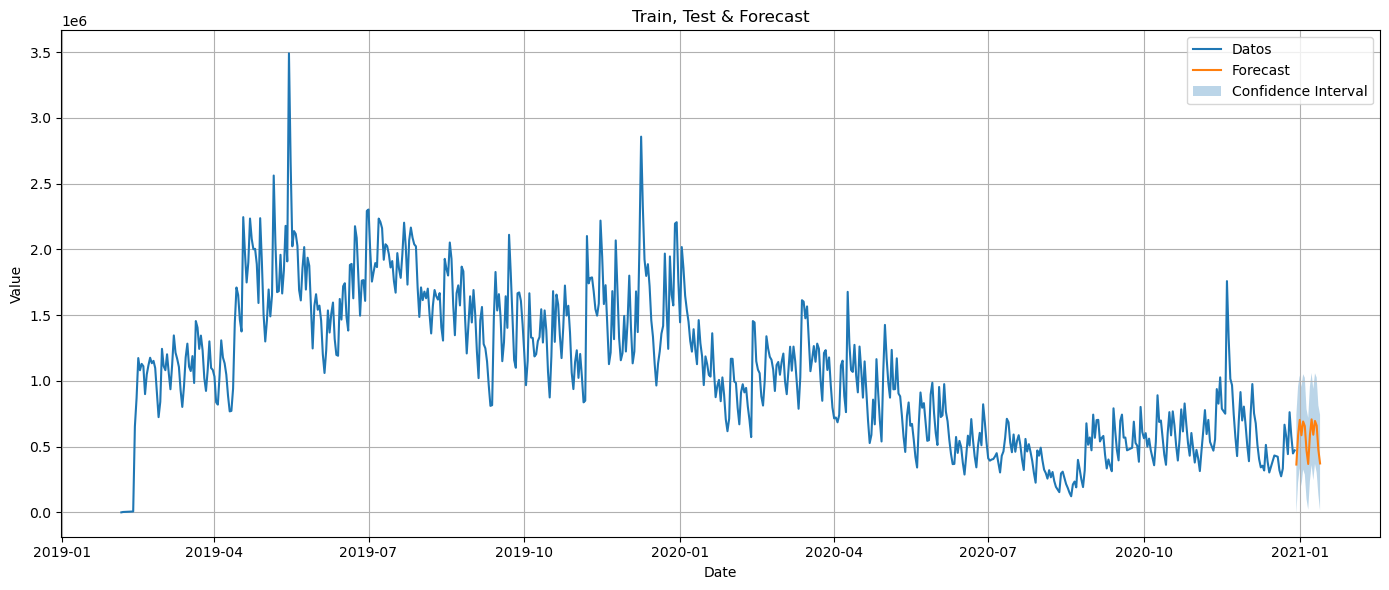

In [21]:
# Se grafica la informacion real
plt.figure(figsize=(14, 6))
# plt.plot(train_df['ds'], train_df['y'], label='Train')
# plt.plot(test_df['ds'], test_df['y'], label='Test')
plt.plot(df_prophet['ds'], df_prophet['y'], label='Datos')


# Graficar predicciones 
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')

# Agregar intervalos de confianza de las predicciones
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 alpha=0.3, label='Confidence Interval')

plt.title('Train, Test & Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Holidays**

In [22]:
feriados_mx = holidays.Mexico(years=[2019,2020,2021])

# Convertir a df para Prophet
df_feriados = pd.DataFrame([
    {'ds': pd.to_datetime(fecha), 'holiday': nombre}
    for fecha, nombre in feriados_mx.items()
])

# Columans para extender el efecto del día festivo para prophet
df_feriados['lower_window'] = 0
df_feriados['upper_window'] = 1

df_feriados.head(10)

,ds,holiday,lower_window,upper_window
0,2019-01-01,Año Nuevo,0,1
1,2019-02-04,Día de la Constitución,0,1
2,2019-03-18,Natalicio de Benito Juárez,0,1
3,2019-05-01,Día del Trabajo,0,1
4,2019-09-16,Día de la Independencia,0,1
5,2019-11-18,Día de la Revolución,0,1
6,2019-12-25,Navidad,0,1
7,2020-01-01,Año Nuevo,0,1
8,2020-02-03,Día de la Constitución,0,1
9,2020-03-16,Natalicio de Benito Juárez,0,1


##### Covid (Aun en proceso)

In [23]:
### Lockdowns 
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'}
   # {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
   # {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110


### **Hyperparameter tuning**

In [ ]:


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale':[0.01, 0.1, 1.0, 10.0],
    'seasonality_mode':['additive', 'multiplicative']

}


all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
mse=[]
mape=[]
metrics=[]

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(holidays=df_feriados,**params,scaling="minmax").fit(df_prophet)  

    # Se realiza validación cruzada con ventana deslizante:
    # - initial='180 days': se entrena con los primeros 180 días de datos,
    # - period='31 days': se genera una nueva predicción cada mes,
    # - horizon='30 days': se evalúa el modelo prediciendo 30 días hacia adelante.
    df_cv = cross_validation(model, initial='180 days', period='31 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

    for col, val in params.items():
        df_p[col] = val
    metrics.append(df_p)

df_all = pd.concat(metrics, ignore_index=True)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
best_params = tuning_results.sort_values('rmse').iloc[0]
print("Mejores parámetros:")
print(best_params)

17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1]

Mejores parámetros:
changepoint_prior_scale               0.5
seasonality_prior_scale               1.0
holidays_prior_scale                  1.0
seasonality_mode           multiplicative
rmse                        329136.334238
Name: 117, dtype: object


In [25]:
df_all

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode
0,30 days,4.475122e+11,668963.539734,528897.197875,0.770254,0.535191,0.481661,0.654661,0.001,0.01,0.01,additive
1,30 days,4.669900e+11,683366.699436,555044.544504,0.847853,0.622838,0.511902,0.690678,0.001,0.01,0.01,multiplicative
2,30 days,4.331620e+11,658150.429171,518546.523551,0.752669,0.518275,0.475886,0.658898,0.001,0.01,0.10,additive
3,30 days,4.622850e+11,679915.416507,551961.533680,0.843177,0.606244,0.510096,0.684322,0.001,0.01,0.10,multiplicative
4,30 days,4.316917e+11,657032.509403,518022.614935,0.751064,0.517264,0.477578,0.661017,0.001,0.01,1.00,additive
...,...,...,...,...,...,...,...,...,...,...,...,...
123,30 days,1.095844e+11,331035.346117,266037.786738,0.341929,0.277209,0.357230,0.713983,0.500,10.00,0.10,multiplicative
124,30 days,1.091429e+11,330367.786178,268749.536536,0.356016,0.297546,0.386820,0.677966,0.500,10.00,1.00,additive
125,30 days,1.085665e+11,329494.281014,265298.078176,0.340879,0.271025,0.357789,0.703390,0.500,10.00,1.00,multiplicative
126,30 days,1.084250e+11,329279.521880,267793.215497,0.355086,0.296732,0.385270,0.699153,0.500,10.00,10.00,additive


In [26]:
best_model=Prophet(scaling="minmax",holidays=df_feriados, changepoint_prior_scale= 0.5,seasonality_prior_scale =1,
                   seasonality_mode='multiplicative',holidays_prior_scale=1)
best_model.fit(df_prophet)

17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
forecast_tuning = best_model.predict(futuro)

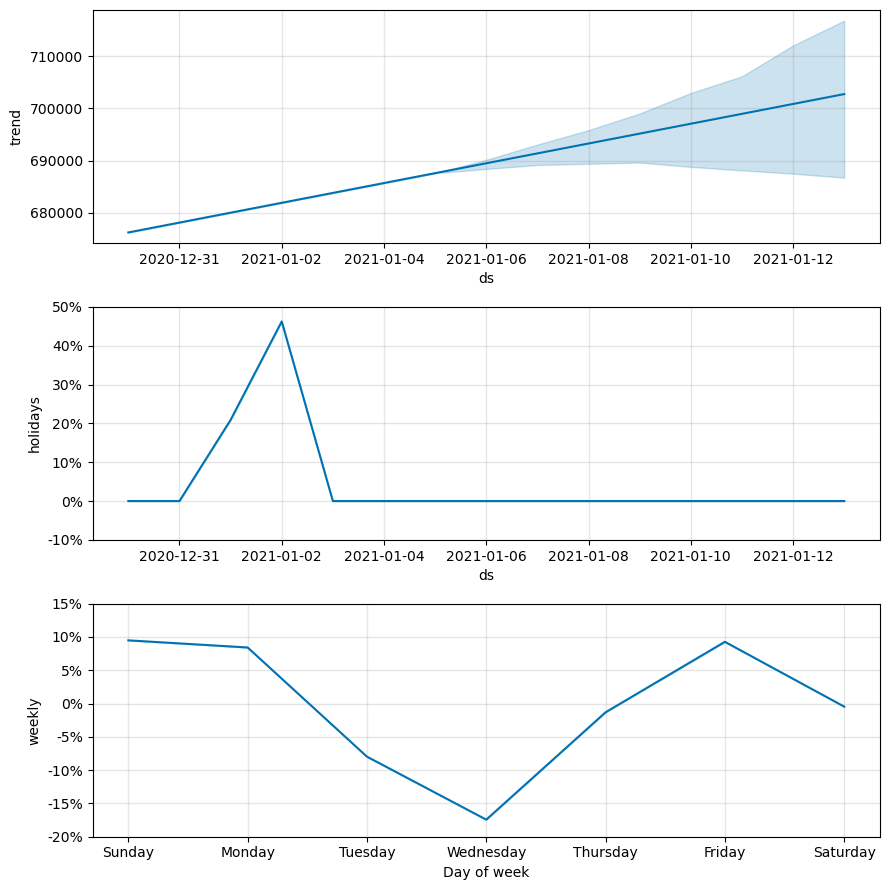

In [28]:
best_model.plot_components(forecast_tuning);

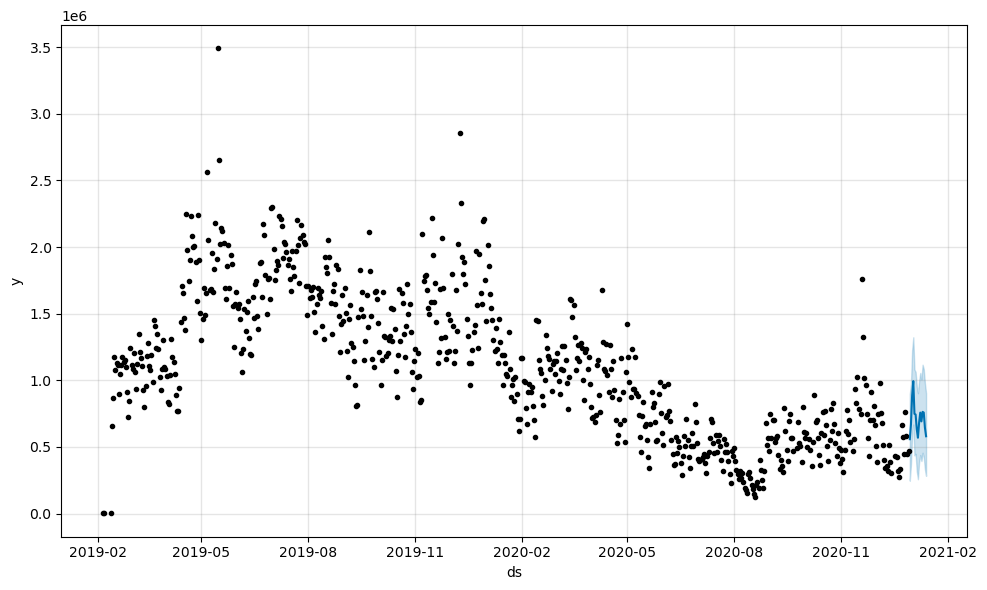

In [29]:
best_model.plot(forecast_tuning);

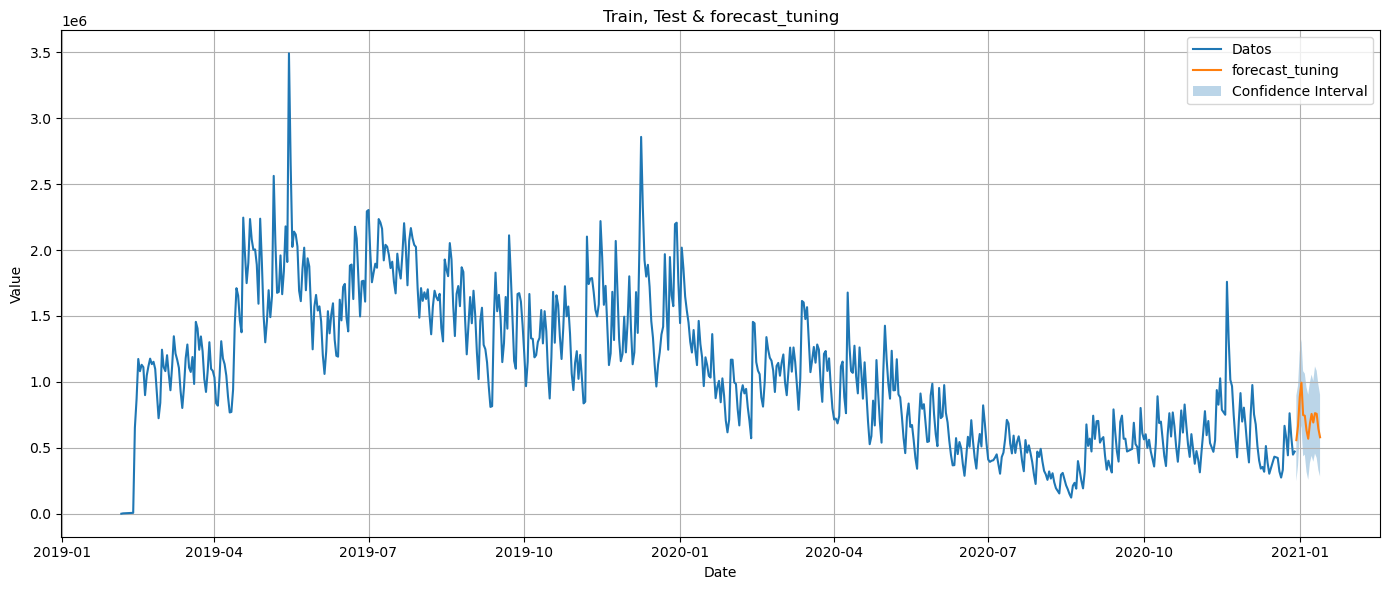

In [30]:
plt.figure(figsize=(14, 6))
# plt.plot(train_df['ds'], train_df['y'], label='Train')
# plt.plot(test_df['ds'], test_df['y'], label='Test')
plt.plot(df_prophet['ds'], df_prophet['y'], label='Datos')
# Graficar predicciones 
plt.plot(forecast_tuning ['ds'], forecast_tuning ['yhat'], label='forecast_tuning')

# Agregar intervalos de confianza de las predicciones
plt.fill_between(forecast_tuning ['ds'],
                 forecast_tuning ['yhat_lower'],
                 forecast_tuning ['yhat_upper'],
                 alpha=0.3, label='Confidence Interval')

plt.title('Train, Test & forecast_tuning')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# def mape(y,y_pred):
#     return round(np.mean(np.abs((y-y_pred)/y))*100,4)